# Portfolio Optimization

Install and import the libraries that we will use for the analysis.

In [1]:
!pip install cvxpy ecos

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import cvxpy as cp # Convex optimization

/Users/daesungkim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Download the close prices of the following tickers from Yahoo Finance.
For each price $P_t^i$ of the ticker $i$ at time $t$, define the returns
$$
    R_t^i=\frac{P_t^i - P_{t-1}^i}{P_{t-1}^i},\qquad r_t^i = \log\left(1+R_t^i\right).
$$

In [100]:
tickers = [
    'AAPL',  # Apple Inc.
    'MSFT',  # Microsoft Corporation
    'NVDA',  # NVIDIA Corporation
    'AMZN',  # Amazon.com Inc.
    'GOOGL', # Alphabet Inc. Class A
    'GOOG',  # Alphabet Inc. Class C
    'META',  # Meta Platforms Inc.
    'TSLA',  # Tesla Inc.
    'AVGO',  # Broadcom Inc.
    'PEP',   # PepsiCo Inc.
    'ADBE',  # Adobe Inc.
    'COST',  # Costco Wholesale Corp.
    'CSCO',  # Cisco Systems Inc.
    'CMCSA', # Comcast Corp.
    'NFLX',  # Netflix Inc.
    'TXN',   # Texas Instruments Inc.
    'INTC',  # Intel Corp.
    'AMGN',  # Amgen Inc.
    'QCOM',  # Qualcomm Inc.
    'HON',   # Honeywell International Inc.
]
data = yf.download(
    tickers,
    start="2022-01-01",
    end="2024-12-31",
    progress=False
)
# Close prices
prices = data["Close"][tickers].dropna()
# Log returns
rets = prices.pct_change().apply(lambda r: np.log(1+r)).dropna()

Define the following parameters.
- The window (`window`): The number of days that we will look back for the expected returns.
- The critical level $\alpha$ (`alpha`)
- VaR Limit (`Var_limit`)

In [101]:
# Parameters
window = 250                 
alpha = 0.05                
z_alp = norm.ppf(alpha)     
VaR_limit = 0.02      

# shape of returns
R = rets.values                
T, n = R.shape

# total mean of the return
mu = rets.mean().values  

### Optimal Weights using VaR

Construct a function that finds the optimal weights for the portfolio.

In [102]:
def optimize_weights(mu, Sigma, VaR_limit, z_alp):
    n = len(mu)
    # VaR function
    def VaR(w):
        mup     = w.dot(mu)
        sigp    = np.sqrt(w @ Sigma @ w)
        return -(mup + z_alp*sigp)
    # Objective
    obj = lambda w: -w.dot(mu)
    # Constraints
    cons = [
        {"type": "ineq", "fun": lambda w: VaR_limit - VaR(w)},
        {"type": "eq",   "fun": lambda w: np.sum(w) - 1.0}
    ]
    # Bounds
    bds = [(0,1)]*n
    # Initial weigt (equally distributed)
    w0   = np.ones(n)/n
    # Optimization solution
    sol = minimize(obj, w0, method="SLSQP", bounds=bds, constraints=cons)
    return sol.x

For $t\ge W$ (where $W=250$ is the window for the rebalance), compute the moving average $\mu_t$ and the covariance $\Sigma_t$ of $r_{t-W+1},\cdots, r_t$.

Then, find the optimal weights $w_t$ corresponding to $\mu_t$ and $\Sigma_t$.


In [103]:
dates = rets.index[window:]
weights = []
for i, date in enumerate(dates, start=window):
    window_rets = rets.iloc[i-window:i]
    mu_t = window_rets.mean().values
    Sigma_t = window_rets.cov().values

    w_t = optimize_weights(mu_t, Sigma_t, VaR_limit, z_alp)
    weights.append(w_t)

weights = np.vstack(weights) 

### Optimal Weights using CVaR

First, use CVXPy to implement convex optimization for optimal weights from the total historic data.

In [104]:
# CVaR Limit
cvar_lim = 0.02       
      
# Initialize the variables
# weights
w = cp.Variable(n)
# threshold
t = cp.Variable() 
# scenario shortfall slack
u = cp.Variable(T)       
# Loss vector under each scenario
loss = - R @ w              

# Constraints
cons_cv = [
    u >= 0,                    
    u >= loss - t,             
    cp.sum(w) == 1,            
    w >= 0,                    
    t + (1/(alpha*T))*cp.sum(u) <= cvar_lim  #
]

# Objective
obj_cv = cp.Maximize(mu @ w)

# Optimization solution
prob_cv = cp.Problem(obj_cv, cons_cv)
prob_cv.solve(solver=cp.SCS)    

w_cv_opt = w.value 
print("Optimal weights under CVaR95%≤2%:", w_cv_opt)

Optimal weights under CVaR95%≤2%: [4.25727456e-07 8.63610421e-07 1.10632871e-07 8.58659182e-07
 5.95811257e-07 5.61472477e-07 5.25948759e-07 6.77856862e-07
 5.15880982e-02 3.32383178e-01 8.38827025e-07 1.06914329e-01
 2.96529837e-02 3.63574832e-07 6.24331783e-07 3.58145387e-07
 1.06721206e-06 2.72165933e-01 6.56839235e-07 2.07286946e-01]


Then, find the optimal rebalancing optimal weights with window=250.

In [105]:
weights_cvar = []
daily_cvar   = []
prev_w       = np.ones(n)/n  

for i, date in enumerate(dates, start=window):
    hist = rets.iloc[i-window : i]
    Rw   = hist.values
    T, n = Rw.shape
    mu_t = hist.mean().values

    # rebuild variables & problem…
    w = cp.Variable(n)
    t = cp.Variable()
    u = cp.Variable(T)
    loss = -Rw @ w
    cons = [
      u >= 0, u >= loss - t,
      cp.sum(w) == 1,
      w >= 0,
      t + (1/(alpha*T))*cp.sum(u) <= cvar_lim
    ]
    prob = cp.Problem(cp.Maximize(mu_t @ w), cons)

    status = prob.solve(solver=cp.ECOS)
    if status not in ("optimal", "optimal_inaccurate"):
        w_opt = prev_w.copy()
        t_opt = daily_cvar[-1] if daily_cvar else 0.0
    else:
        w_opt = w.value
        t_opt = t.value
        prev_w = w_opt.copy()

    weights_cvar.append(w_opt)

    loss_vals = -Rw.dot(w_opt)
    u_vals    = np.maximum(loss_vals - t_opt, 0)
    cvar_est  = t_opt + (1/(alpha*T))*u_vals.sum()
    daily_cvar.append(cvar_est)


In [106]:
portfolio_weights = pd.DataFrame(weights_cvar, index=dates, columns=rets.columns)
daily_cvar_limit  = pd.Series(daily_cvar,   index=dates, name="CVaR95")



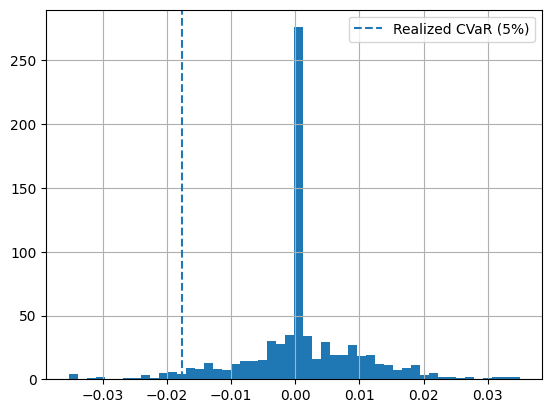

In [107]:
# daily portfolio return series
strat_rets = (portfolio_weights.shift(1) * rets).sum(axis=1)
# drop the first day
strat_rets = strat_rets.iloc[1:]
# histogram
strat_rets.hist(bins=50)
plt.axvline(-realized_cvar, linestyle='--', label="Realized CVaR (5%)")
plt.legend()

In [108]:
# Cumulative return
cum_ret = (1 + strat_rets).prod() - 1
print(f"Cumulative Return: {cum_ret:.2%}")

# Annualized return
ann_ret = (1 + cum_ret) ** (252 / len(strat_rets)) - 1
print(f"Annualized Return: {ann_ret:.2%}")

# Annualized volatility
ann_vol = strat_rets.std(ddof=1) * np.sqrt(252)
print(f"Annualized Volatility: {ann_vol:.2%}")

# Sharpe ratio
rf = 0.0  # Risk-free rate
sharpe = (strat_rets.mean() * 252 - rf) / ann_vol
print(f"Sharpe Ratio: {sharpe:.2f}")

Cumulative Return: 88.62%
Annualized Return: 23.77%
Annualized Volatility: 14.86%
Sharpe Ratio: 1.51


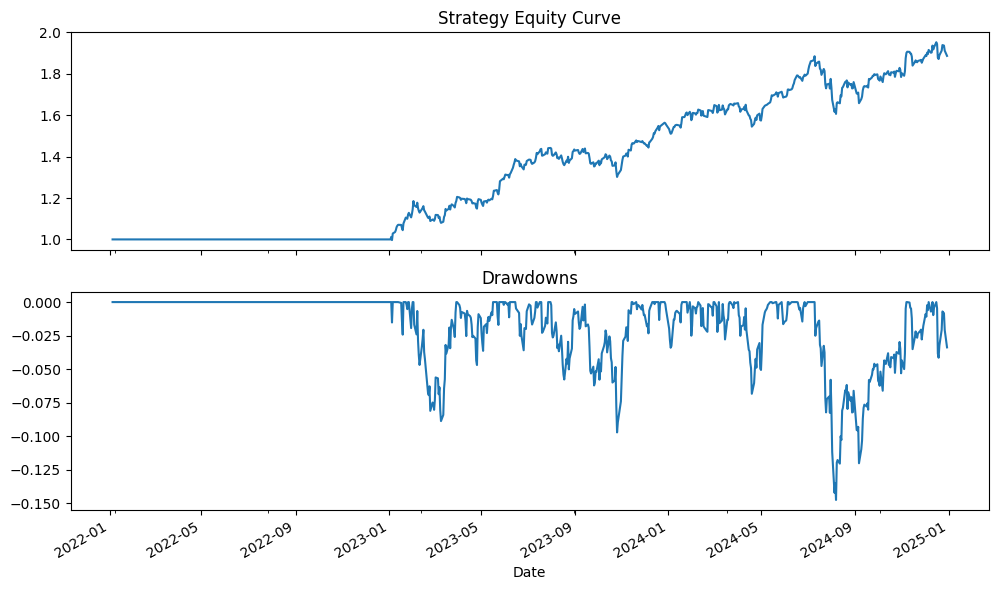

In [109]:
# wealth & drawdowns
wealth = (1 + strat_rets).cumprod()
running_max = wealth.cummax()
drawdowns = (wealth - running_max) / running_max
max_dd = drawdowns.min() 

# graphs
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
wealth.plot(ax=ax[0], title="Strategy Equity Curve")
drawdowns.plot(ax=ax[1], title="Drawdowns")
plt.tight_layout()